# Data Preparation, Feature Engineering and Concatenation  

This notebook is used to generate and organize the features that will serve as inputs for training. Specifically, to align two complementary sources of information:  
- CNN-extracted diffractogram features, which capture patterns directly from diffraction data, and  
- Patolli-generated descriptors, which encode solid-state principles into structured representations of material properties for predictive modeling.  



In [1]:
#Import of all libraries and utilities
import tensorflow.keras.layers as layers
import tensorflow.keras.models as models
import tensorflow.keras.utils as kutils
import tensorflow.keras.callbacks as callbacks
import tensorflow.keras.optimizers as optimizer
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as PRFS
from sklearn.utils import shuffle
from sklearn.metrics import precision_recall_fscore_support as PRFS
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import datetime
import time
import copy
import os

2025-09-19 23:12:07.696685: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-09-19 23:12:07.727796: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-09-19 23:12:07.735855: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-09-19 23:12:07.760901: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-19 23:12:08.753986: W tensorflow/compiler/tf2

Building the dataframes from the target collection and the locality functions

In [2]:
df = pd.read_pickle('./support/hseDatasetSummary.pkl')
db = pd.read_pickle('./support/hseDataset.pkl')
fij_diccio = np.load('./support/Rc_25_pot_2.0_diccio.npy', allow_pickle=True).item()

Work will be conducted on crystalline materials characterized by up to 10 Wyckoff sites.

### Functions for descriptor construction

In [3]:
def raw_features_extractor(sites=-1, df=pd.DataFrame):
    
    """
    Function taken from patolli.py and modified afterward.
    Parameters: 
        sites: int, it constrains the creation of the compounds collection
                to samples with a maximum number of Wyckoff sites.
    Returns:
        X: A tensor which dimensions are the samples x sites x pair atomic radius and electronegativity.
            This is saved as raw_features.npy
        S: A tensor which dimensions are the samples x sites x multiplicity of the site
            This is saved as multiplicites.npy
        fracsum: A tensor which dimensions are the samples x sites x the occupation fraction of the site
            This is saved as occupation_fractions.npy
        df: The collection of the compounds created with the function create_collection.
    """
  
    start=time.time()
    
    datos=pd.read_csv('./support/datosrahm.csv')
    datos=datos.fillna(-1)

    dicc=dict(datos[['Symbol','Z']].values)

    dicc['D']=1
    dicc['Bk']=97
    dicc['Cf']=98
    dicc['Es']=99
    dicc['Fm']=100
    dicc['Md']=101
    dicc['No']=102
    dicc['Lr']=103
    
    if sites == -1:
        max_sitios = df['sites'].max()
    else: 
        max_sitios = sites

    df=df[df['sites'] <= max_sitios].reset_index(drop=True)
    
    X=np.zeros((len(df),max_sitios,104))
    mult=np.zeros((len(df),max_sitios))
    wyckmul=np.load('./support/WyckoffSG_dict.npy', allow_pickle=True).item()['wyckmul']
    
    todelete = list()    
    for row in range(len(df)):
        
        item=df['WyckOcc'][row]
        sitios=list(item.values()) 
        sitocc=np.zeros((len(sitios),104))
        spacegroup = str(df['sgnum'][row]).zfill(3)
        
        try:
        
            s=[int(wyckmul[spacegroup][i]) for j in [list(item.keys()) for item in \
               sitios] for i in j]
        
        except:
            print('The compound with the cif ', df['cif'][row], ' will be deleted from the collection.')
            print('The collection will be updated')
            todelete += [row]
            continue
            
        occs=[]
        for i in range(len(sitios)):

            for j in list(sitios[i].values()):
                
                ocupacion=np.array(list(j.values()))
                llaves=[llave.replace('+','').replace('-','').replace('1',
                        '').replace('2','').replace('3','').replace('4',
                                   '') for llave in np.array(list(j.keys()))]
                llaves=[llave.replace('.','') for llave in llaves]
                llaves=[llave.replace('5','').replace('6','').replace('7',
                        '').replace('8','').replace('9','').replace('0',
                                   '') for llave in llaves]
                vector=np.zeros((1,104))
                occs=[sum(ocupacion)]+occs
                
                try:
                    
                    idx=[dicc[k] for k in llaves]
                
                except:
                    
                    print('The compound with the cif ', df['cif'][row], ' will be deleted from the collection.')
                    print('The collection will be updated')
                    todelete += [row]
                    continue
                    
                for k in idx:
                    vector[0][k-1] = ocupacion[idx.index(k)]
                
            sitocc[i]=vector
    
        while sitocc.shape[0] != max_sitios:
            sitocc=np.concatenate((np.zeros((1,104)),sitocc))
            s=[0]+s
        
        X[row,:,:]=sitocc
        mult[row]=s
    
    S = np.expand_dims(mult,axis=2)
    features=datos.iloc[:,2:5].values
    x=X[:,:,:96]
    print(x.shape)
    fracsum = np.expand_dims(np.sum(x,axis=2), axis=2)
    
    x=np.dot(x,features)    
    
    x = np.delete(x, todelete, axis=0)
    S = np.delete(S, todelete, axis=0)
    fracsum = np.delete(fracsum, todelete, axis=0)
    df = df.drop(df.index[todelete]).reset_index(drop=True)
    
    print('Atomic radii and electronegativities for each Wyckoff site extracted in',
          round(time.time()-start,2),' s')   
    
    return x, S, fracsum, df

def add_rad_elec(X = np.ones((1,1,1))):
    """
    This function gets the average atomic radii and electronegativities per site for each compound. 
    Parameters:
	X: a Numpy array
    Returns:
	x: a Numpy array. The dimensions of the array correspond to a tensor of shape 
	(samples,1,atomic radii and electronegativites).
    """
    X = X[:,:,:2]
    x = X.reshape((X.shape[0], 1, X.shape[1]*X.shape[2]))
    return x

def compute_quotients(X = np.zeros((1,1,2))):
    """
    Returns the atomic radii pair quotients and the atomic radii 
    pair sum - quotients as a numpy array. This is the first part of
    all the features used to train the ANNs. The output of 
    this function is saved as X.npy
    
    Parameters:
        X: A numpy array, which is created with the function raw_features_extractor
    Returns:
        X: A numpy array of dimension [samples,1,features]
    """
    
    start=time.time()
    rad = X[:,:,1]

    drad = np.asarray([[item[0]/item[1] if item[1] != 0 else 0 for item in list(itertools.combinations(rad[sample],2))] \
                        for sample in range(X.shape[0])])

    dradsum = np.asarray([[item[0]/item[1] if item[1] != 0 else 0 for item in itertools.combinations([ \
                       item[0]+item[1] for item in list(itertools.combinations(rad[sample],2))], 2)] \
                       for sample in range(drad.shape[0])])
    
    drad = np.reshape(drad,(drad.shape[0],1,drad.shape[-1]))
    drads = np.reshape(dradsum,(dradsum.shape[0],1,dradsum.shape[-1]))
    
    Xq = np.concatenate((drad,drads), axis=2)
    print('Geometric and packing factors computed in', round(time.time()-start,2),' s')
    #np.save('X', Xq)
    
    return Xq

def append_local_functions(X = np.zeros((1,1,1)), df = pd.DataFrame(), 
                           local_function='./support/Rc_25_pot_2.0_diccio'):
    """
    Returns the features with the local functions. In case the local function
    does not exist for a sample in the collection, this is deleted and the
    collection is updated. The X.npy is updated.
    
    Parameters:
        X: The numpy array created with compute_quotients
        df: The pandas DataFrame created with raw_features_extractor
        local_function: The numpy dictionary having the local function to use.
    Returns:
        X: The numpy array with all neccesary features for the ANNs.
        df: The pandas DataFrame updated.
    """
    start = time.time()
    print('The dictionary ' + local_function + ' will be used for local functions')
    fij = np.load(local_function + '.npy', allow_pickle=True).item()
    
    delrow = list()
    n = df['sites'].max()
    
    f = np.zeros((df.shape[0],n,n))
    
    for row in range(df.shape[0]):
        if df['name'][row] not in fij.keys():
            delrow += [row]
        else:
            loc = fij[df['name'][row]]
            s = loc.shape[1]
            f[row,-s:,-s:] = loc
    
    if len(delrow) != 0:
        
        print('The compounds with the next cifs will be deleted since ',
              'their local functions are not currently available')
        print([df['name'][i] for i in delrow])
        print('The compound collection will be updated')
        
        totake = [i for i in range(df.shape[0]) if i not in delrow]
        df = df.take(totake).reset_index(drop=True)
        X = X[totake]
        f = f[totake]
        #df.to_csv('compounds_collection.csv', index=None)
    '''
    #Esta parte trabaja para las funciones de localidad cuando incorporan la diferencia de electronegatividades
    
    fn = np.zeros((f.shape[0], f.shape[1], f.shape[2] - 1))        
    for item in range(f.shape[0]):
        delec = f[item]
        delec = delec[~np.eye(delec.shape[0], dtype=bool)].reshape(delec.shape[0],-1)
        fn[item] = delec
    
    f = fn
    '''
    f = f.reshape((f.shape[0], 1, f.shape[1]*f.shape[2]))
    print(X.shape, f.shape)
    
    X = np.concatenate((X,f), axis = 2)
    print('Local functions appended to features in ', round(time.time()-start,2),' s')
    return X, df

The process begins with the construction of descriptors for each sample. If this is not feasible, the sample is discarded and the collection summary is updated accordingly.

In [4]:
xraw, multiplicity, fracSum, df = raw_features_extractor(sites=10, df=df)

notANobleGas = [i for i in np.argwhere((xraw == -1).sum(axis=(1,2)) == 0)[:,0]]

if len(notANobleGas):
    print('Dropping rows having a noble gas in the formula')
    print('There are', len(notANobleGas),'rows remaining')

xraw = xraw[notANobleGas]
multiplicity= multiplicity[notANobleGas]
fracSum = fracSum[notANobleGas]
df = df.iloc[notANobleGas,:].reset_index(drop=True)

(9290, 10, 96)
Atomic radii and electronegativities for each Wyckoff site extracted in 0.61  s
Dropping rows having a noble gas in the formula
There are 9275 rows remaining


In [5]:
x = add_rad_elec(X = xraw)
xq = compute_quotients(xraw)

#x = np.concatenate((x, xq), axis=-1)

Geometric and packing factors computed in 2.03  s


In [6]:
x,df = append_local_functions(x, df)

The dictionary ./support/Rc_25_pot_2.0_diccio will be used for local functions
The compounds with the next cifs will be deleted since  their local functions are not currently available
['SM-10200', 'SM-10269', 'SM-10928', 'SM-10937', 'SM-11313', 'SM-11551', 'SM-11563', 'SM-11632', 'SM-11634', 'SM-11638', 'SM-11688', 'SM-11689', 'SM-11862', 'SM-11893', 'SM-1196', 'SM-12014', 'SM-12032', 'SM-12079', 'SM-12098', 'SM-12129', 'SM-12142', 'SM-12147', 'SM-12164', 'SM-1223', 'SM-12285', 'SM-1229', 'SM-1237', 'SM-12453', 'SM-12552', 'SM-12675', 'SM-12679', 'SM-12975', 'SM-13001', 'SM-13002', 'SM-13061', 'SM-13078', 'SM-13151', 'SM-13219', 'SM-13286', 'SM-13329', 'SM-13349', 'SM-13382', 'SM-13396', 'SM-13406', 'SM-13419', 'SM-13420', 'SM-13422', 'SM-13458', 'SM-13479', 'SM-13487', 'SM-13504', 'SM-13517', 'SM-13549', 'SM-13568', 'SM-13570', 'SM-13826', 'SM-13945', 'SM-14005', 'SM-14013', 'SM-14022', 'SM-14039', 'SM-14040', 'SM-14110', 'SM-14169', 'SM-14246', 'SM-14248', 'SM-15062', 'SM-15094', 'S

Descriptor construction is complete. Band gap information will be collected to generate output values.

In [7]:
idxdiccio = {k:v for v,k in enumerate(db.snumat_id.values)}
y = db.iloc[[idxdiccio[df['name'][row]] for row in range(df.shape[0])]][['bg_gga', 'bg_gga_opt', 'bg_hse', 'bg_hse_opt']].values


In [8]:
patolli_complete=pd.concat([df['name'],pd.DataFrame(y)],axis=1)
patolli_complete.columns = ['cif'] + ['bg_gga', 'bg_gga_opt', 'bg_hse', 'bg_hse_opt']
patolli_complete.shape

(9062, 5)

Output values distribution.

In [9]:
y.mean(axis=0), y.std(axis=0), y.max(axis=0), y.min(axis=0)

(array([1.74408222, 2.40261587, 2.80793064, 3.52104157]),
 array([1.25422112, 1.67128289, 1.55570872, 1.92821398]),
 array([10.114853, 24.270356, 12.495444, 26.906879]),
 array([ 0.      ,  0.      , -0.054436, -0.054436]))

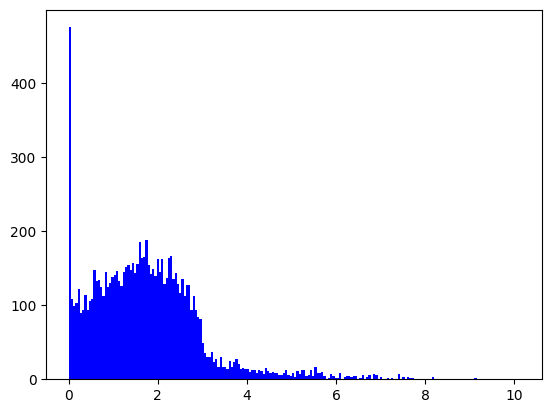

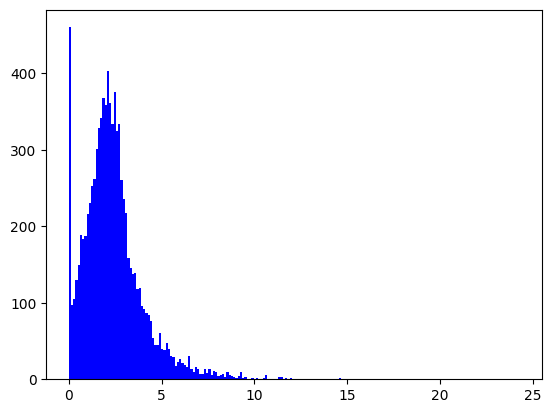

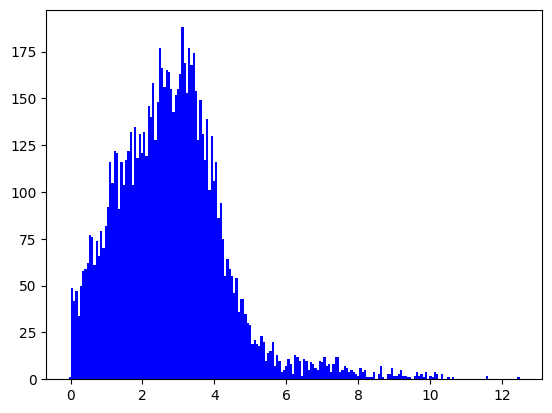

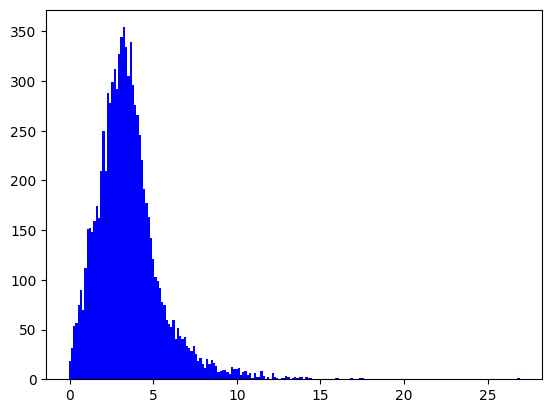

In [10]:
for outputValue in range(4):
    
    plt.figure()
    plt.hist(y[:,outputValue], bins=200, color='blue')
    plt.show()

Band gaps will be constrained to a range between 0 and the mean value plus two standard deviations. The sample collection (df) and the descriptor collection (x) are then updated.

In [11]:
conditions = dict()
for row in range(y.shape[-1]):
    conditions[row] = np.intersect1d(np.argwhere(0 < y[:,row])[:,0], np.argwhere(y[:,row] <= y[:,row].mean() + 2*y[:,row].std())[:,0])


idxRightOutputs = np.intersect1d(np.intersect1d(conditions[0], conditions[1]), np.intersect1d(conditions[2], conditions[3]))

x = x[idxRightOutputs]
y = y[idxRightOutputs]
df = df.iloc[idxRightOutputs].reset_index(drop=True)
df.shape

(8134, 6)

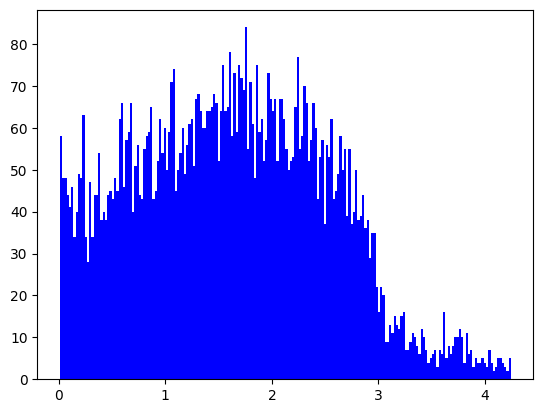

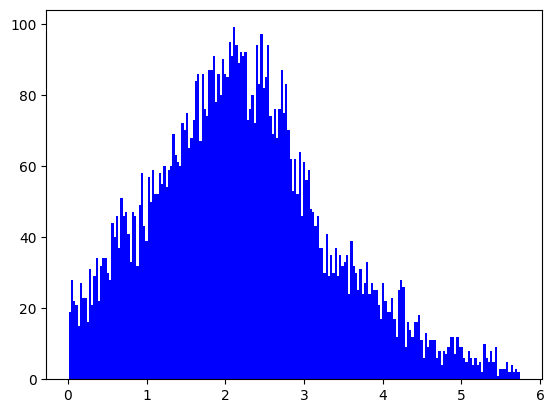

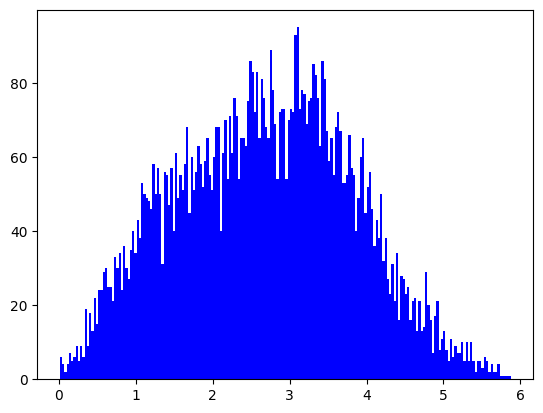

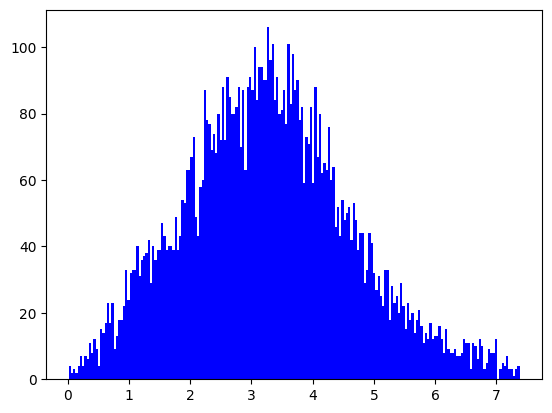

In [12]:
for outputValue in range(4):
    
    plt.figure()
    plt.hist(y[:,outputValue], bins=200, color='blue')
    plt.show()

Z-score scaling

In [13]:
mean = np.mean(x, axis=(1,2), keepdims = True)
std = np.std(x, axis=(1,2), keepdims=True)

xnorm = (x-mean)/std

In [14]:
patolli_df=pd.concat([df['name'],pd.DataFrame(xnorm[:,0,:]),pd.DataFrame(y)],axis=1)
patolli_df.columns = ['cif']+list(patolli_df.columns[1:-4]) + ['bg_gga', 'bg_gga_opt', 'bg_hse', 'bg_hse_opt']
patolli_df.dtypes
patolli_y=pd.concat([df['name'],pd.DataFrame(y)],axis=1)
patolli_y.columns = ['cif'] + ['bg_gga', 'bg_gga_opt', 'bg_hse', 'bg_hse_opt']
patolli_y.shape



(8134, 5)

### Splitting the full dataset into training–validation and test sets

In [15]:
testFraction = 0.20

In [16]:
np.random.choice.__doc__.split('\n')# df.shape[0]
np.random.seed(3451)
idxtest = np.random.choice(range(df.shape[0]), size = int(testFraction*df.shape[0]), replace=False)
idxtraval = [i for i in range(df.shape[0]) if i not in idxtest]

xtravalOr = xnorm[idxtraval]
xtest = xnorm[idxtest]
np.save('data/patolli_generated_data/patolli_gen_desc_xtest_2s_fgsm.npy',xtest)
ytravalOr = y[idxtraval]
ytest = y[idxtest]
np.save('data/patolli_generated_data/patolli_gen_desc_ytest_2s_fgsm.npy',ytest)
dftravalOr = df.iloc[idxtraval].reset_index(drop=True)
dftest = df.iloc[idxtest].reset_index(drop=True)


In [17]:
print(xtest.shape)

(1626, 1, 120)


### Randomization

In [18]:
xtraval, ytraval, dftraval = shuffle(xtravalOr, ytravalOr, dftravalOr, random_state=3451)
xtraval, ytraval, dftraval = shuffle(xtraval, ytraval, dftraval, random_state=3451)
xtraval, ytraval, dftraval = shuffle(xtraval, ytraval, dftraval, random_state=3451)
np.save('data/patolli_generated_data/patolli_gen_desc_xtraval_2s_fgsm.npy',xtraval)
np.save('data/patolli_generated_data/patolli_gen_desc_ytraval_2s_fgsm.npy',ytraval)
dftraval.to_csv('data/patolli_generated_data/patolli_gen_desc_dftraval_2s.csv',index=False)
print(xtraval.shape, ytraval.shape, dftraval.shape)

(6508, 1, 120) (6508, 4) (6508, 6)


Load patolli and CNN-extracted features 

In [19]:
# Load patolli generated features
#patolli_df=pd.read_csv('patolli_for_transfer.csv')
#patolli_y=pd.read_csv('patolli_targets_for_transfer.csv')

# Load extracted diffractogram-based features
x_features = np.load("data/cnn_extracted_data/Apr_18_13_35_2024/featureExtraction/hfset.npy")
x_features_df = pd.DataFrame(x_features)


# Load dataset with material IDs (cif) and labels
df_base = pd.read_csv("data/cnn_extracted_data/Apr_18_13_35_2024/featureExtraction/dataset.csv")

# Combine IDs with features
dataset = pd.concat([df_base["cif"], x_features_df], axis=1)

# Merge with target values

dataset = dataset.merge(patolli_y, on="cif", how="inner")
dataset.shape


(6765, 165)

Load and preparation of pre-built test and training/validation splits

In [20]:
# Load train-validation/test splits
df_test = pd.read_csv("data/cnn_extracted_data/Apr_18_13_35_2024/dftest.csv")
df_traval = pd.read_csv("data/cnn_extracted_data/Apr_18_13_35_2024/dftraval.csv")

# Drop unused HSE bandgap column and reset index
df_test = df_test.drop(columns=["bg_hse"]).reset_index(drop=True)
df_traval = df_traval.drop(columns=["bg_hse"]).reset_index(drop=True)

# Ensure unique CIF identifiers
df_test["cif"] = df_test["cif"].drop_duplicates()
df_traval["cif"] = df_traval["cif"].drop_duplicates()

# Manual inspection
display(df_test.head(),df_traval.shape)
display(df_traval.head(),df_test.shape)



,cif
0,SM-17469
1,SM-5479
2,SM-14957
3,SM-3801
4,SM-17845


(25984, 1)

,cif
0,SM-10014
1,SM-10015
2,SM-10018
3,SM-10019
4,SM-10020


(6496, 1)

In [21]:
# Merge training set with full dataset (features + targets)
traval_df = df_traval.merge(dataset, on="cif", how="inner")
display(traval_df.shape)

# Merge test set
test_df = df_test.merge(dataset, on="cif", how="inner")
display(test_df.dtypes)


(5425, 165)

cif            object
0             float32
1             float32
2             float32
3             float32
               ...   
159           float32
bg_gga        float64
bg_gga_opt    float64
bg_hse        float64
bg_hse_opt    float64
Length: 165, dtype: object

In [22]:
# Save merged splits
traval_df.to_csv("data/cnn_extracted_data/extracted_only_traval_fgsm.csv", index=False)
test_df.to_csv("data/cnn_extracted_data/extracted_only_test_fgsm.csv", index=False)

# Extract target values (bandgaps) as numpy arrays
y_traval = traval_df[["bg_gga", "bg_gga_opt", "bg_hse", "bg_hse_opt"]].to_numpy()
y_test = test_df[["bg_gga", "bg_gga_opt", "bg_hse", "bg_hse_opt"]].to_numpy()

print(y_traval.shape, y_test.shape)


(5425, 4) (1340, 4)


In [23]:
# Drop non-feature columns to isolate feature arrays
x_traval = traval_df.drop(columns=["cif", "bg_gga", "bg_gga_opt", "bg_hse", "bg_hse_opt"]).values
x_test = test_df.drop(columns=["cif", "bg_gga", "bg_gga_opt", "bg_hse", "bg_hse_opt"]).values

display(x_test.shape)
display(x_traval.shape)


(1340, 160)

(5425, 160)

In [24]:
# Bandgap labels of interest
bandgap_cols = ["bg_gga", "bg_gga_opt", "bg_hse", "bg_hse_opt"]

# Merge full dataset with patolli_df
concat_df = dataset.merge(patolli_df, on="cif", how="inner")

# Drop duplicate target columns from merge
concat_df = concat_df.drop(["bg_gga_x", "bg_gga_opt_x", "bg_hse_x", "bg_hse_opt_x"], axis=1)

# Rename columns: cif + feature indices + bandgaps
concat_df.columns = ["cif"] + list(range(280)) + bandgap_cols

display(concat_df)


,cif,0,1,2,3,4,5,6,7,8,...,274,275,276,277,278,279,bg_gga,bg_gga_opt,bg_hse,bg_hse_opt
0,SM-1000,0.540492,-0.930807,1.735219,-0.901577,-1.335915,0.193955,-0.599575,-1.133359,0.713234,...,-0.248870,-0.248870,-0.248870,-0.248870,2.998947,4.220380,1.395717,1.666532,3.088441,3.443899
1,SM-10008,1.848330,-0.844999,1.047875,-0.372645,-1.361206,0.738601,-0.493712,1.159457,1.111116,...,0.756114,0.830319,0.460875,0.470997,2.149566,1.022493,2.448348,2.448348,3.409682,3.409682
2,SM-10012,0.952382,-0.990264,0.862427,-1.220746,-1.081140,-0.720694,-1.380363,-1.320711,-0.263088,...,-0.370325,-0.370325,-0.370325,2.926676,2.832751,1.390666,0.388741,1.884429,1.028657,2.560054
3,SM-10014,0.515531,-0.705162,0.685380,-1.372145,-0.093186,0.511909,0.622013,1.483238,-0.082329,...,-0.343609,-0.343609,-0.343609,0.635939,3.155183,2.775969,2.405025,2.405025,3.224964,3.224964
4,SM-10015,0.556142,-1.233051,0.092460,-0.346032,-0.862858,0.355043,0.935332,0.858745,-0.222300,...,-0.344006,-0.344006,-0.344006,0.621580,3.166369,3.005626,1.977195,1.977195,2.711083,2.711083
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6760,SM-9988,1.207602,0.166007,0.351233,0.046756,-0.759212,0.664314,-0.285939,0.039608,1.185475,...,0.711226,-0.038275,0.252931,0.383517,0.229461,-0.329368,2.171310,2.944789,3.152018,3.939579
6761,SM-9989,0.890940,-0.724979,0.779244,-0.329344,-1.495707,0.341718,-0.372225,-0.856384,1.082122,...,0.595135,-0.225783,0.346405,0.384439,0.228336,-0.354465,1.408309,1.408309,2.279059,2.279059
6762,SM-999,1.563062,-0.901040,1.027722,-0.137728,-1.715994,0.185685,1.413454,-0.362167,0.862928,...,-1.338341,-0.912537,-0.898079,-0.926154,-0.952240,-1.535339,0.311664,0.377655,2.399116,2.399116
6763,SM-9991,1.767061,0.080335,1.771478,-0.923001,-1.183890,1.348524,0.961352,0.574679,1.658796,...,-0.399936,-0.399936,-0.109544,0.376818,0.863854,2.239832,0.262277,0.907452,0.781563,1.457649


In [25]:
# Save concatenated training set
traval_concat_df = df_traval.merge(concat_df, on="cif", how="inner")
traval_concat_df.columns = ["cif"] + list(range(280)) + bandgap_cols
traval_concat_df.to_csv("data/concatenated_data/traval_concat_df_2_fgsm.csv", index=False)
# Save concatenated test set
test_concat_df = df_test.merge(concat_df, on="cif", how="inner")
test_concat_df.columns = ["cif"] + list(range(280)) + bandgap_cols
test_concat_df.to_csv("data/concatenated_data/test_concat_df_2_fgsm.csv", index=False)
